### First Question. Are present any season effect of the number of crimes in London?

Tha aim of this notebook is to analyze the London Crimes events and identify any seasonal patterns.

In [1]:
import os
import pandas as pd
from pandas.io import gbq
from google.cloud import bigquery
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "deeplearning-97d854aac156.json"

# Instantiates a client
bigquery_client = bigquery.Client()
# Query for collecting data

query ="""
SELECT year, month,  sum(value) as number 
FROM  `bigquery-public-data.london_crime.crime_by_lsoa`
group by  month,year
order by  number DESC; 
"""

df = gbq.read_gbq(query, dialect='standard' );

/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### First, let's have a look at the time series

In [2]:
df=df.sort_values(['year','month'])
df['date'] = pd.to_datetime(df.year.map(str) + '-' + df.month.map(str), format = '%Y-%m');
df.set_index('date', inplace=True);

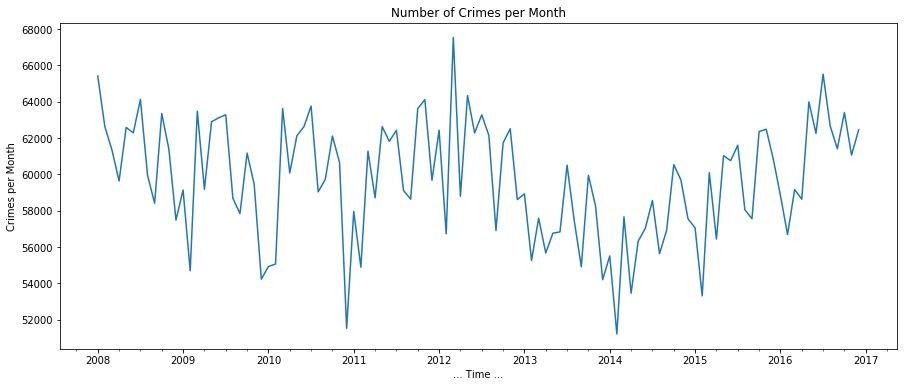

In [3]:
df.number.plot(figsize=(15, 6))
plt.title('Number of Crimes per Month')
plt.ylabel('Crimes per Month')
plt.xlabel('... Time ...')
plt.show()

### Uhm... there are some fluctuations... let's check for patterns

 As a first step, we normalize for the number of days on each month. So we can use the average number of events per day (otherwise months with 31 days would weight more than month with less day, ex. February)

In [4]:
# Dictionary, day for Month.
month={1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}

df['CrimePerDay'] = df.apply(lambda x:(x.number/month.get(x.month,0)), axis=1)

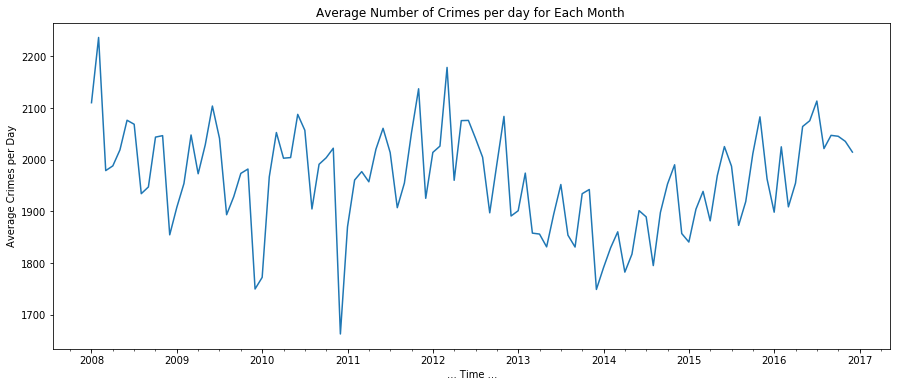

In [5]:
df.CrimePerDay.plot(figsize=(15, 6))
plt.title('Average Number of Crimes per day for Each Month ')
plt.ylabel('Average Crimes per Day')
plt.xlabel('... Time ...')
plt.show()

This time series is similar to the previous one (has expected ), but if you look at it closely there are some differences between the two charts.

### Let's check if the fluctuations have a monthly pattern, or it is just a random walk.¶

Let's aggregate the data for each month of the year.



In [6]:
# We have the data from January 2008 to December 2016
# 9 full years. 9 years * 12 mounths (108 rows)

# checking number of rows

df.shape[0]==108

True

In [7]:
df=df.groupby(["month"]).sum()

df['month']=df.index
df=df[['month','number']]
df['CrimePerDay']=df.apply(lambda x:(x.number/month.get(x.month,0)), axis=1)

/home/enzo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


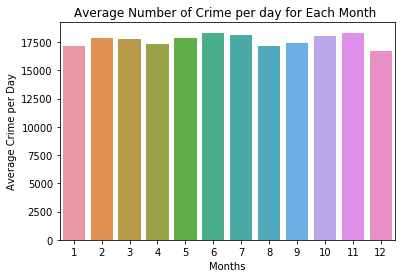

In [8]:
sns.barplot(x=df.month, y=df['CrimePerDay']);

plt.title('Average Number of Crimes per Day for Each Month ');
plt.ylabel('Average Crime per Day');
plt.xlabel('Months of the Year');


### OK let's focus on the visualization of variations ....

Let's see the variation percentages.

We rescale using the average number of crimes per day as a baseline

In [9]:
baseline = df.CrimePerDay.mean()
df['diff_percentage'] = 100 * (df.CrimePerDay/baseline - 1)

Creating two markers around one standard deviation, for visual reference...


In [10]:
upper=100 * ((df.CrimePerDay.mean() + df.CrimePerDay.std())/baseline -1)
lower=100 * ((df.CrimePerDay.mean() - df.CrimePerDay.std())/baseline-1)

/home/enzo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


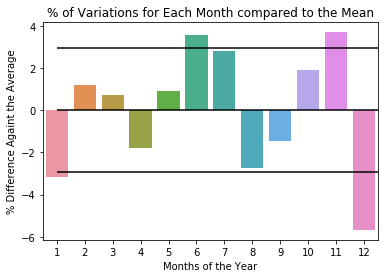

In [11]:
sns.barplot(x=df['month'], y=df['diff_percentage'])
plt.hlines(upper, 0, 12)
plt.hlines(0,0,12)
plt.hlines(lower, 0, 12);
plt.title('% of Variations for Each Month compared to the Mean');
plt.ylabel('% Difference Againt the Average');
plt.xlabel('Months of the Year');

From the chart above appears to be a reduction of the number of crimes in December and January...

We may call it Christmas effect :)

We have an increase in November as a sort of rush before holiday.

A similar pattern appears in the Summer time, where there is a peak in June and July with a significative decrease

on the holiday season (August).